# Group Analysis: FOOOFed EEG Analysis: Rest

Apply FOOOF to resting state EEG data, and compare details between young and old group. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload

In [2]:
from os import listdir
from os.path import join as pjoin

import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, pearsonr

from fooof import FOOOFGroup
from fooof.analysis import get_band_peak_group
from fooof.core.funcs import expo_nk_function

In [3]:
# Import custom code for this analysis
import sys
sys.path.append('../code')

%autoreload 2
from plts import *
from utils import *

# Settings

In [4]:
# Set path to load results from
res_path = '/Users/tom/Documents/Research/1-Projects/fooof/2-Data/Results/'

# Set whether to drop outlier subjects, in terms of FOOOF Goodness-of-Fit metrics
drop_outliers = True

# Set indices to separate groups
from settings import YNG_INDS, OLD_INDS

# Set average function to use
avg_func = np.nanmean
#avg_func = np.nanmedian

# Wether to save out plots or not
save_fig = False

print('Number of young subjects:  ', len(YNG_INDS))
print('Number of  old  subjects:  ', len(OLD_INDS))

Number of young subjects:   17
Number of  old  subjects:   14


### Load FOOOF Data

In [5]:
# Set the data folder to run
dat_folder = 'FOOOF-AllCh'

In [6]:
# Get files
files = listdir(pjoin(res_path, dat_folder))
files = [file for file in files if 'RAW' in file]
files.sort()

In [7]:
# Load all subject FOOOFGroups
fg = FOOOFGroup()
fgs = []
for file in files:
    fg.load(file, pjoin(res_path, dat_folder))
    fgs.append(fg.copy())

### Extract FOOOF Data

In [8]:
# Grab alphas from each subject
ch_ind = 28  # 28 is Oz
alphas = np.empty(shape=[len(fgs), 3])
for ind, fg in enumerate(fgs):
    #alphas[ind, :] = get_band_peak_group(fg.get_params('gaussian_params'), [7, 14], len(fg))[ch_ind, :]
    alphas[ind, :] = get_band_peak_group(fg.get_params('peak_params'), [7, 14], len(fg))[ch_ind, :]

In [9]:
# Grab aperiodic params from each subject
ch_ind = 47 # 47 is Cz
aps = np.empty(shape=[len(fgs), 2])
for ind, fg in enumerate(fgs):
    aps[ind, :] = fg.get_params('aperiodic_params')[ch_ind]
offs = aps[:, 0]
exps = aps[:, 1]

In [10]:
# Extract error & R^2 from FOOOF fits
ch_ind = 28  # Oz

errs = []; r2s = []

for fg in fgs:
    errs.append(fg.get_results()[ch_ind].error)
    r2s.append(fg.get_results()[ch_ind].r_squared)

errs = np.array(errs)
r2s = np.array(r2s)

### Check For Outliers

This check and drop procedure finds & drops subjects for which the FOOOF goodness-of-fit metrics are statistical outliers, indicating poor fits. 

In [11]:
def check_outliers(dat, thresh):
    return list(np.where(np.abs(dat - np.mean(dat)) > thresh * np.std(dat))[0])

In [12]:
std_thresh = 2.5
err_outliers = check_outliers(errs, std_thresh)
std_outliers = check_outliers(r2s, std_thresh)

In [13]:
# Check if the same outliers are detected for each GoF measure
print(err_outliers)
print(std_outliers)

[21]
[21]


In [14]:
# Combine outlier list across GoF metrics
bad_inds = set(err_outliers + std_outliers)

In [15]:
# Drop outlier GoF values
if drop_outliers:
    print('DROPPING {} OUTLIER'.format(len(bad_inds)))
    for bad_ind in bad_inds:
        print('\tRemoving index # ', bad_ind)
        try:
            YNG_INDS.remove(bad_ind)
            OLD_INDS.remove(bad_ind)
        except: pass

DROPPING 1 OUTLIER
	Removing index #  21


## Aperiodic Comparisons

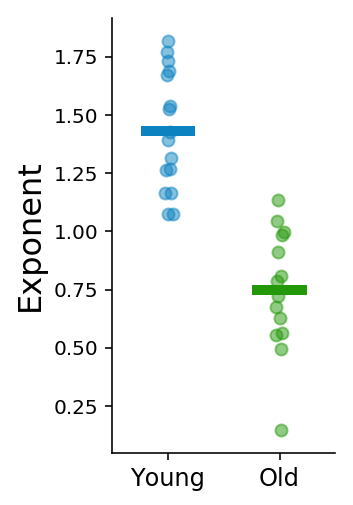

In [16]:
# Plot exponent comparison
plot_comp_scatter(exps, 'Exponent', save_fig=save_fig, save_name='exponents')

In [17]:
# Statistically test exponent difference
print_stat('Exponent t-test', *ttest_ind(exps[YNG_INDS], exps[OLD_INDS]))
print('Mean Difference: \t', np.mean(exps[YNG_INDS]) - np.mean(exps[OLD_INDS]))

Exponent t-test: 	  7.2386 	 0.0000
Mean Difference: 	 0.6843925394143859


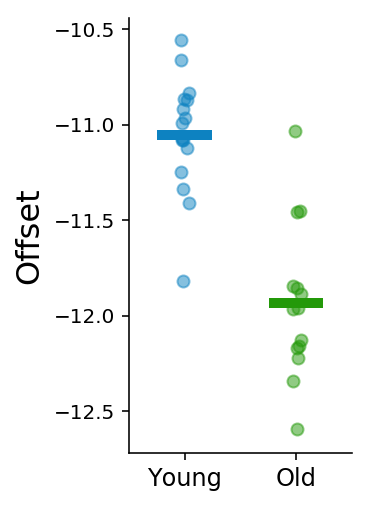

In [18]:
# Plot offset comparison
plot_comp_scatter(offs, 'Offset', save_fig=save_fig, save_name='Offsets')

In [19]:
# Statistically test offset difference
print_stat('Offset t-test', *ttest_ind(offs[YNG_INDS], offs[OLD_INDS]))
print('Mean Difference: \t', np.mean(offs[YNG_INDS]) - np.mean(offs[OLD_INDS]))

Offset t-test: 	  6.8150 	 0.0000
Mean Difference: 	 0.8819863462390032


## Periodic Comparisons

### Check total alpha power

'Total alpha power', from the FOOOF model, is the model results of the aperiodic + the alpha peak amplitude.

In [20]:
# Set the channel to extract alpha power from
ch_ind = 28 # Oz

# Collect the aperiodic parameters for each subject
oz_aps = np.empty(shape=[len(fgs), 2])
for ind, fg in enumerate(fgs):
    oz_aps[ind, :] = fg.get_params('aperiodic_params')[ch_ind]

# Calculate total alpha as the value of the BG function at alpha CF, please the amplitude of the alpha peak
tot_alphas = []
for bg, cf, amp in zip(oz_aps, alphas[:, 0], alphas[:, 1]):

    # If there is no alpha, get the aperiodic component at CF of 10, and set alpha amplitude to zero
    if np.isnan(cf):
        cf, amp = 10, 0
    
    # Calculate the value of the aperiodic function at the alpha-CF, and add the alpha-amp
    tot_alphas.append(expo_nk_function(np.array([cf]), *bg)[0] + amp)
    
tot_alphas = np.array(tot_alphas)

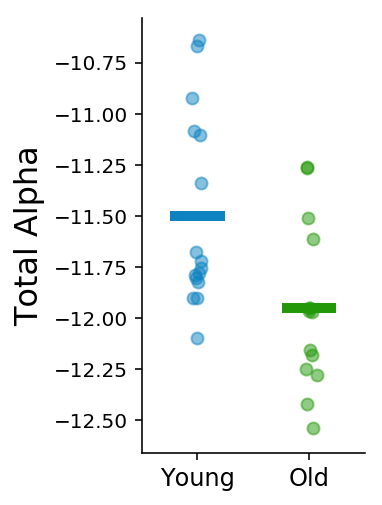

In [21]:
# Plot total alpha - total power values from the FOOOF model at individualzed alpha CFs
#  Note: this is equivalent to doing an individualed alpha frequency analysis, comparing total power
plot_comp_scatter(tot_alphas, 'Total Alpha', save_fig=save_fig, save_name='TotalAlpha')

In [22]:
print_stat('Total Alpha t-test', *ttest_ind(tot_alphas[YNG_INDS], tot_alphas[OLD_INDS]))
print('Mean Difference: \t', np.mean(tot_alphas[YNG_INDS]) - np.mean(tot_alphas[OLD_INDS]))

Total Alpha t-test: 	  2.8001 	 0.0092
Mean Difference: 	 0.45104318321427783


### Check number of extracted oscillations

In [23]:
ch_ind = 28  # Oz
n_oscs = []
for fg in fgs:
    n_oscs.append(fg.get_results()[ch_ind].peak_params.shape[0])
n_oscs = np.array(n_oscs)

In [24]:
print('# Oscs Yng:', np.mean(n_oscs[YNG_INDS]))
print('# Oscs Old:', np.mean(n_oscs[OLD_INDS]))
print_stat('\n# Oscs Diff', *ttest_ind(n_oscs[YNG_INDS], n_oscs[OLD_INDS]))

# Oscs Yng: 4.1875
# Oscs Old: 4.285714285714286

# Oscs Diff: 	 -0.2390 	 0.8128


### Statistically Compare Peak Parameters

In [25]:
# Check how many subjects don't have alpha
print('Number of subjects with no alpha:')
print('\t YNG:\t', sum(np.isnan(dat[YNG_INDS])))
print('\t OLD: \t', sum(np.isnan(dat[OLD_INDS])))

Number of subjects with no alpha:


NameError: name 'dat' is not defined

In [ ]:
# Check differences in alpha measures, between groups
for d_ind, label in zip([0, 1, 2], ['CF', 'PW', 'BW']):

    # Select data
    dat = alphas[:, d_ind]
    you_dat = list(dat[YNG_INDS][~np.isnan(dat[YNG_INDS])])# + [0] * sum(np.isnan(dat[YNG_INDS]))
    old_dat = list(dat[OLD_INDS][~np.isnan(dat[OLD_INDS])])# + [0] * sum(np.isnan(dat[OLD_INDS]))
    
    # Statistically compare and check average difference between groups
    print(label)
    print_stat('\tt-test', *ttest_ind(you_dat, old_dat))
    print('\tMean Diff: \t  {:1.3f}'.format(np.mean(you_dat - np.mean(old_dat))))

### Alpha - Center Frequency

In [ ]:
plot_comp_scatter(alphas[:, 0], 'Alpha CF', save_fig=save_fig, save_name='AlphaCF')

### Alpha - Power

In [ ]:
plot_comp_scatter(alphas[:, 1], 'Alpha PW', save_fig=save_fig, save_name='AlphaPW')

### Alpha - Bandwidth

In [ ]:
plot_comp_scatter(alphas[:, 2], 'Alpha BW', save_fig=save_fig, save_name='AlphaBW')

### Alpha Oscillations - Individual Variation

In [ ]:
plot_oscillations(alphas[YNG_INDS, :], save_fig=save_fig, save_name='YoungAlphas')

In [ ]:
plot_oscillations(alphas[OLD_INDS, :], save_fig=save_fig, save_name='OldAlphas')

### Overlap of Individualized Alpha with Canonical Band



In [ ]:
def calc_overlaps(alphas):
    """
    The approach to do this is taken from:
    https://stackoverflow.com/questions/32551610/overlapping-probability-of-two-normal-distribution-with-scipy
    """

    # Note: current approach presumes no NaNs
    overlaps = []
    mean, std = 10, 2

    for alpha in alphas:

        # Get individial CF - keep BW @ 2
        ind_mean, ind_std = alpha[0], 2

        # Normalize all deviations from canonical to be lower than 10 Hz
        if ind_mean <= mean:
            m1, std1, m2, std2 = ind_mean, ind_std, mean, std
            #flip = False
        else:
            m1, std1, m2, std2 = mean, std, ind_mean, ind_std
            #flip = True    

        intersect = get_intersect(m1, m2, std1, std2)
        overlap = get_overlap(intersect, m1, m2, std1, std2)
        
#         if flip:
#             overlap = 1 - overlap
#         else:
#             overlap = -(1 - overlap)
        
        overlaps.append(overlap)

    overlaps = np.array(overlaps)
    
    return overlaps

In [ ]:
overlaps = calc_overlaps(alphas)

In [ ]:
# Check average (overall) of overlaps
print('ALL avg overlap: ', np.mean(np.abs(overlaps)), '\n')

# Check average per yng & old group, and test difference
print('YNG avg overlap:', np.mean(overlaps[YNG_INDS]))
print('OLD avg overlap:', np.mean(overlaps[OLD_INDS]))

print_stat('\nDiff Overlap:', *ttest_ind(overlaps[YNG_INDS], overlaps[OLD_INDS]))

In [ ]:
plot_comp_scatter(overlaps, 'Alpha Overlaps', save_fig=save_fig, save_name='AlphaOverlaps')

In [ ]:
# Calculate the differences per subject from a 10 Hz center
overlap_diffs = alphas[:, 0] - 10
yng_overlaps = overlap_diffs[YNG_INDS]
old_overlaps = overlap_diffs[OLD_INDS]

In [ ]:
print('Directional Differences from 10 Hz Center, by Group')
print('YNG-Diff {: 1.2f}'.format(np.mean(yng_overlaps)))
print('OLD-Diff {: 1.2f}'.format(np.mean(old_overlaps)))
print('\n')
print('Absolute Differences from 10 Hz Center, by Group')
print('YNG-Diff {: 1.2f}'.format(np.mean(np.abs(yng_overlaps))))
print('OLD-Diff {: 1.2f}'.format(np.mean(np.abs(old_overlaps))))

#### Plot Overlap

Plot for an example case, using the average deviation from 10 Hz. 

In [ ]:
# Get the average deviation from center of 10 Hz
avg_deviation = np.mean(np.abs(alphas[:, 0] - 10))

In [ ]:
# Compare canonical 10 +/- 2, with a gaussian centered with average deviation
#  Note: in this approach, average deviation shifted below 10 Hz
#    This is arbitrary - still captures deviations above 10 - could be equivalently calculated that way
m1, m2, std1, std2 = 10-avg_deviation, 10, 2, 2
r = get_intersect(m1, m2, std1, std2)

# Check the overlap of the 'average' subject
print(get_overlap(r, m1, m2, std1, std2))

In [ ]:
# Plot the overlap of canonical and average shifted alpha
plot_overlap(m1, m2, std1, std2, save_fig=save_fig, save_name='CanonicalCompare')

### Compare 'Frequency Specific' Differences from Aperiodic

In [ ]:
# Plot aperiodics with a the comparison of differences at each frequency
plot_aperiodic(aps, save_fig=save_fig, save_name='Aperiodics')

### Compare 'Peaks' from Aperiodic

Question: compare with just exponent, or with exponent & offset?

In [ ]:
# Pull out the difference in power, at 10 Hz, arising from BG difference
exp_alphas = []
for ap in aps:
    exp_alphas.append(expo_nk_function(np.array([10]), *ap)[0])
    #exp_alphas.append(expo_nk_function(np.array([10]), 1, ap[1])[0])
    #exp_alphas.append(expo_nk_function(np.array([10]), ap[0], 1)[0])
exp_alphas = np.array(exp_alphas)

In [ ]:
# Compare the 'alpha' difference - coming only from aperiodic differences
plot_comp_scatter(exp_alphas, "AP 'Alpha'", save_fig=save_fig, save_name='APAlpha')

In [ ]:
# Statistically test difference in 'AP-Alpha'
print_stat('AP-Al Diff', *ttest_ind(exp_alphas[YNG_INDS], exp_alphas[OLD_INDS]))

#### Compare across all frequencies

Note: Old version of figure. 

In [ ]:
# Calculate aperiodic components of power spectra for each subject
freqs = range(2, 50, 2)
model_aps = []
for ap in aps:
    model_aps.append(expo_nk_function(np.array(freqs), *ap))
    #model_aps.append(expo_nk_function(np.array(freqs), 0, ap[1]))
    #model_aps.append(expo_nk_function(np.array(freqs), ap[0], 1))
model_aps = np.array(model_aps)

In [ ]:
# Calculate average difference per frequency, and plot comparison
avg_diffs, p_vals = calc_ap_comps(freqs, model_aps)
plot_ap_band_diff(freqs, avg_diffs, p_vals)

## Controls - check errors

Check that there isn't a systematic different in model fit error / R^2 that could explain differences

In [ ]:
# Compare errors between groups
plot_comp_scatter(errs)

In [ ]:
# Compare errors between groups
plot_comp_scatter(r2s)

In [ ]:
# Statistically compare errors and R^2 between groups
print_stat('Errors', *ttest_ind(errs[YNG_INDS], errs[OLD_INDS]))
print_stat('R-squared', *ttest_ind(r2s[YNG_INDS], r2s[OLD_INDS]))

In [ ]:
# Check the correlation between errors and R^2s
print_stat('Errs & R2s ', *pearsonr(errs, r2s))

## Correlations between FOOOF Features

In [ ]:
# Seperate out Oz BG parameters
oz_offs = oz_aps[:, 0]; oz_exps = oz_aps[:, 1]

In [ ]:
# Correlation between aperiodic features
print_stat('Cz - Off & Sl ', *pearsonr(offs, exps))
print_stat('Oz - Off & Sl ', *pearsonr(oz_offs, oz_exps))

In [ ]:
# Correlations between oscillation features
print_stat('Osc - Cf  & Amp', *pearsonr(alphas[:, 0], alphas[:, 1]))
print_stat('Osc - Cf  & BW ', *pearsonr(alphas[:, 0], alphas[:, 2]))
print_stat('Osc - Amp & BW ', *pearsonr(alphas[:, 1], alphas[:, 2]))

In [ ]:
# Correlations between exponent and oscillation features
print_stat('CF  & Sl ', *pearsonr(alphas[:, 0], oz_exps))
print_stat('Amp & Sl ', *pearsonr(alphas[:, 1], oz_exps))
print_stat('BW  & Sl ', *pearsonr(alphas[:, 2], oz_exps))

In [ ]:
# Oz alpha with Cz exponent (?)
print_stat('Oz CF  & Cz Sl', *pearsonr(alphas[:, 0], exps))
print_stat('Oz Amp & Cz Sl', *pearsonr(alphas[:, 1], exps))
print_stat('Oz BW  & Cz Sl', *pearsonr(alphas[:, 2], exps))

In [ ]:
# Correlation between FOOOF outputs and error
print_stat('Oz Cf  & Err', *pearsonr(errs, alphas[:, 0]))
print_stat('Oz Amp & Err', *pearsonr(errs, alphas[:, 1]))
print_stat('Oz BW  & Err', *pearsonr(errs, alphas[:, 2]))
print_stat('Oz Sl  & Err', *pearsonr(errs, oz_exps))

In [ ]:
# Correlation between FOOOF outputs and r2s
print_stat('Oz Cf   & R^2', *pearsonr(r2s, alphas[:, 0]))
print_stat('Oz Amp  & R^2', *pearsonr(r2s, alphas[:, 1]))
print_stat('Oz BW   & R^2', *pearsonr(r2s, alphas[:, 2]))
print_stat('Oz Sl   & R^2', *pearsonr(r2s, oz_exps))